In [1]:
# Import necessary modules
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import numpy as np
import subprocess
import matplotlib.pyplot as plt



**Check the form of shapefile (point or line or polygon)**

In [2]:


# Define the path to your shapefile
shapefile_path = '/Users/macbokpro/Desktop/AIS/AnchorageAreas.shp'

# Read the shapefile
gdf = gpd.read_file(shapefile_path)

# Print the first few rows to see the data
print(gdf.head())

# Check the geometry type of each feature
geometry_types = gdf.geom_type
print("Geometry types in the shapefile:")
print(geometry_types.value_counts())

# Print the unique geometry types
unique_geometry_types = gdf.geom_type.unique()
print(f"Unique geometry types: {unique_geometry_types}")

# Verify if all geometries are of a specific type
if all(gdf.geom_type == 'Polygon'):
    print("All geometries are polygons.")
elif all(gdf.geom_type == 'LineString'):
    print("All geometries are lines.")
elif all(gdf.geom_type == 'Point'):
    print("All geometries are points.")
else:
    print("The shapefile contains mixed geometry types.")


     INSIDE_X   INSIDE_Y     CENTROID_X     CENTROID_Y   Shape_Leng  \
0 -118.177132  33.751509  211612.861827 -351138.116846  1748.494224   
1 -118.170730  33.749480  212202.386518 -351343.456828  1902.221417   
2 -118.164030  33.747685  212818.406691 -351522.301446  1755.908367   
3 -118.178010  33.745121  211553.246964 -351840.247355  2041.029997   
4 -118.170072  33.743356  212281.872973 -352012.468055  2372.649177   

      Shape_Area                                           geometry  
0  243286.796614  POLYGON Z ((211619.486 -351416.319 0, 211604.6...  
1  287946.809135  POLYGON Z ((212255.377 -351641.531 0, 212240.0...  
2  245354.389789  POLYGON Z ((212791.911 -351800.504 0, 212777.1...  
3  331504.105302  POLYGON Z ((211665.853 -352144.946 0, 211650.6...  
4  447978.520678  POLYGON Z ((212275.249 -352390.029 0, 212257.9...  
Geometry types in the shapefile:
Polygon    81
Name: count, dtype: int64
Unique geometry types: ['Polygon']
All geometries are polygons.


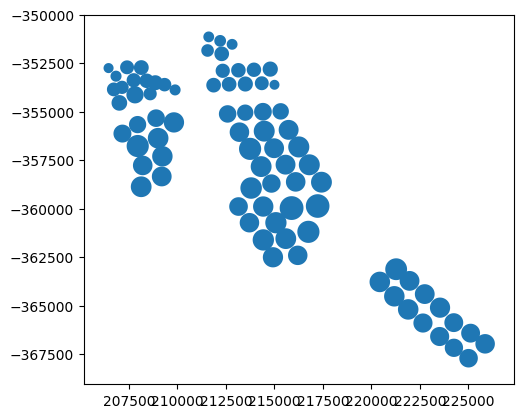

In [3]:
# Define static variables
Anchorage_area = "/Users/macbokpro/Desktop/AIS/AnchorageAreas.shp"

# Define a function to read input arguments (adapted for notebook use)
def read_arg(input_file, output_file, grid_size=None):
    return input_file, output_file, grid_size

#map the anchorage area data
anchorage = gpd.read_file(Anchorage_area)
anchorage.plot()
plt.show()

**CSV fiel to shape file & spatial join with anchorqage area shape file**

In [11]:
# Function to convert CSV to point shapefile
def csv_to_point(input_file, output_file):
    # Read input csv file as a pandas dataframe with low memory option to handle mixed data types
    df = pd.read_csv(input_file, on_bad_lines='skip', low_memory=False)

    # Check the initial DataFrame
    print("Initial DataFrame head:")
    print(df.head())
    print("Initial DataFrame shape:", df.shape)

    # Convert dataframe to geodataframe using LAT and LON fields
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.LON, df.LAT, crs="EPSG:4326"))

    # Check the converted GeoDataFrame
    print("Converted GeoDataFrame head:")
    print(gdf.head())
    print("Converted GeoDataFrame shape:", gdf.shape)

    # Read Anchorage Area file
    anchorage = gpd.read_file(Anchorage_area)
    print("anchorage GeoDataFrame head:")
    print(anchorage.head())
    print("anchorage GeoDataFrame shape:", anchorage.shape)

    # Ensure the CRS of the anchorage area is compatible
    anchorage = anchorage.to_crs(epsg=4326)

    # Intersect AIS points with anchorage area
    gdf = gpd.sjoin(gdf, anchorage, how="inner", predicate='within')

    # Check the result of the spatial join
    print("GeoDataFrame after spatial join head:")
    print(gdf.head())
    print("GeoDataFrame after spatial join shape:", gdf.shape)

    if gdf.empty:
        print("No points within the anchorage area. Check the input data and the anchorage area shapefile.")

    # Rename columns to be within 10 characters for shapefile compatibility
    gdf.rename(columns={
        'BaseDateTime': 'BaseDateTi',
        'TransceiverClass': 'Transceive',
        'index_right': 'index_righ',
        'LENGTH': 'LENGTH_1'
    }, inplace=True)

    # Output geodataframe to shapefile
    gdf.to_file(output_file)
    
# Example
input_file = '/Users/macbokpro/Desktop/AIS/AIS_2019_12:29_1:29.csv'
point_output_file = 'points.shp'

# Step 1: Convert CSV to Point Shapefile
csv_to_point(input_file, point_output_file)





Initial DataFrame head:
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  368064650  2020-01-01T00:00:00  33.72365 -118.27967   0.0  360.0    511.0   
1    3669999  2020-01-01T00:00:01  33.72340 -118.28068   0.1  258.5    511.0   
2  367661930  2020-01-01T00:00:02  33.72981 -118.27564   0.1  301.7    511.0   
3  368024740  2020-01-01T00:00:03  33.72909 -118.18749  16.7   85.0     81.0   
4  248951000  2020-01-01T00:00:03  33.68217 -118.20249   9.3  198.7    201.0   

       VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0             NaN         NaN      NaN         NaN    15.0     NaN    NaN   
1             NaN         NaN      NaN         NaN     0.0     NaN    NaN   
2  MICHELLE SLOAN  IMO9747819  WDH8832        31.0     0.0    24.0    NaN   
3             NaN         NaN      NaN         NaN    15.0     NaN    NaN   
4             NaN         NaN      NaN         NaN     0.0     NaN    NaN   

   Draft  Cargo TransceiverClass

**Screening for SOG (speed over ground) less than 1 knot**

Point Shapefile Head:
        MMSI           BaseDateTi       LAT        LON  SOG    COG  Heading  \
0  368020980  2020-01-01T00:01:12  33.73443 -118.22965  0.0   13.5    229.0   
1  356818000  2020-01-01T00:01:50  33.72938 -118.16300  0.0  240.9    240.0   
2  311000136  2020-01-01T00:01:56  33.73544 -118.15072  0.2  347.0    253.0   
3  368024740  2020-01-01T00:02:06  33.72956 -118.17726  7.9   91.5     90.0   
4  538007883  2020-01-01T00:02:18  33.69612 -118.14106  0.0  328.7    241.0   

          VesselName         IMO CallSign  ...  Cargo  Transceive  index_righ  \
0               None        None     None  ...    NaN           A          17   
1               None        None     None  ...    NaN           A          10   
2  CAPRICORN VOYAGER  IMO9330604    C6UZ5  ...    NaN           A           7   
3               None        None     None  ...    NaN           A           9   
4               None        None     None  ...    NaN           A          47   

     INSIDE_X   

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Daily Counts:
date
2019-12-31    48
2020-01-01    46
2020-01-02    47
2020-01-03    45
2020-01-04    40
2020-01-05    61
2020-01-06    51
2020-01-07    36
2020-01-08    46
2020-01-09    37
2020-01-10    35
2020-01-11    41
2020-01-12    35
2020-01-13    42
2020-01-14    43
2020-01-15    48
2020-01-16    51
2020-01-17    54
2020-01-18    46
2020-01-19    53
2020-01-20    47
2020-01-21    34
2020-01-22    42
2020-01-23    44
2020-01-24    41
2020-01-25    42
2020-01-26    40
2020-01-27    36
2020-01-28    38
2020-01-29    28
Name: MMSI, dtype: int64


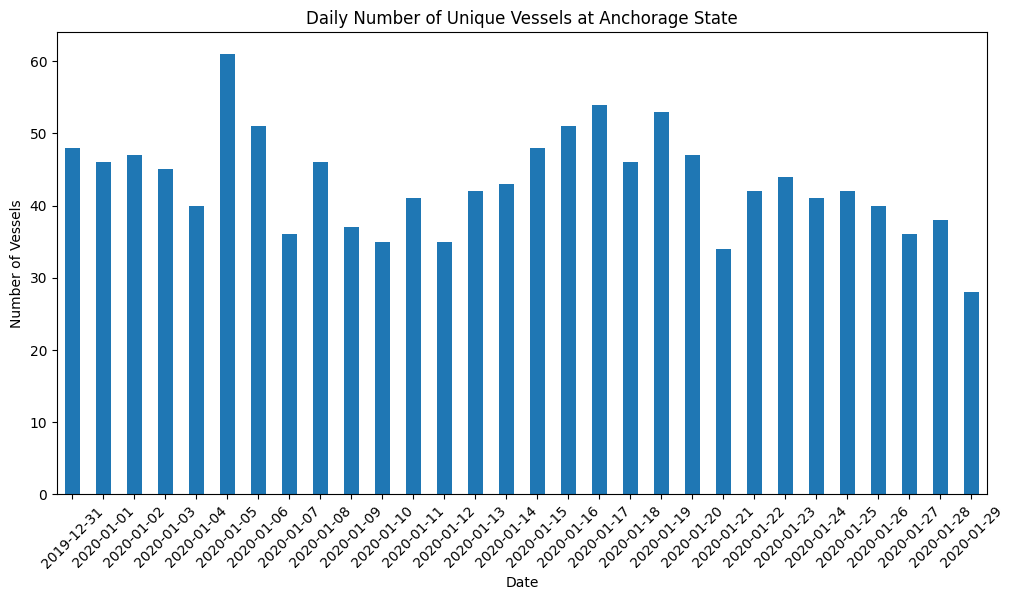

In [12]:
# Load the generated point shapefile
gdf_point = gpd.read_file(point_output_file)

# Print and visualize the input GeoDataFrame
print("Point Shapefile Head:")
print(gdf_point.head())

# Filter vessels at anchorage state (SOG < 1)
anchorage_vessels = gdf_point[gdf_point['SOG'] < 1]

# Print the filtered GeoDataFrame
print("Anchorage Vessels Head:")
print(anchorage_vessels.head())

# Count the number of unique vessels at anchorage state for each day
anchorage_vessels['BaseDateTi'] = pd.to_datetime(anchorage_vessels['BaseDateTi'])
anchorage_vessels['date'] = anchorage_vessels['BaseDateTi'].dt.date
daily_counts = anchorage_vessels.groupby('date')['MMSI'].nunique()

# Print daily counts
print("Daily Counts:")
print(daily_counts)

# Plot daily counts
daily_counts.plot(kind='bar', figsize=(12, 6))
plt.title('Daily Number of Unique Vessels at Anchorage State')
plt.xlabel('Date')
plt.ylabel('Number of Vessels')
plt.xticks(rotation=45)
plt.show()


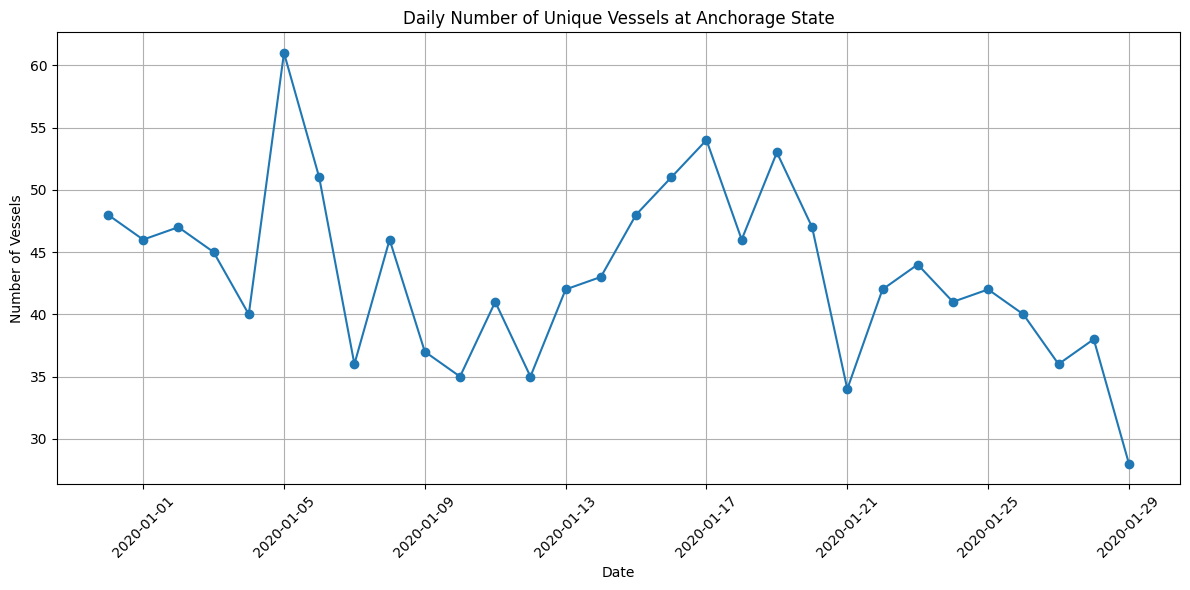

In [13]:
# Plot daily counts as a line chart
plt.figure(figsize=(12, 6))
plt.plot(daily_counts.index, daily_counts.values, marker='o', linestyle='-')
plt.title('Daily Number of Unique Vessels at Anchorage State')
plt.xlabel('Date')
plt.ylabel('Number of Vessels')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

**Total Acnhoraqge vessels in Jan.2020**

Number of unique vessels at anchorage state: 251


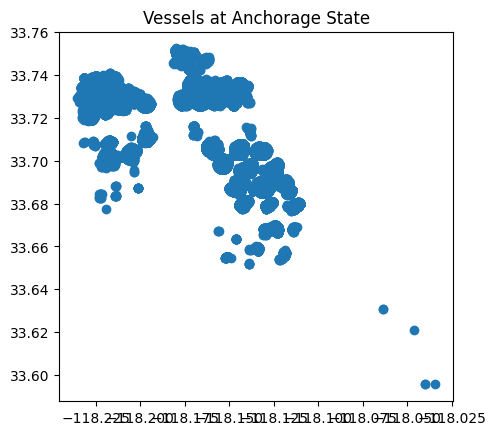

In [14]:
# Read input shapefile
gdf_point = gpd.read_file(point_output_file)

# Filter vessels at anchorage state (SOG < 1)
anchorage_vessels = gdf_point[gdf_point['SOG'] < 1]

# Count the number of unique vessels at anchorage state
unique_anchorage_vessels = anchorage_vessels['MMSI'].nunique()
print(f"Number of unique vessels at anchorage state: {unique_anchorage_vessels}")

# Optionally, plot the anchorage vessels to visualize them
anchorage_vessels.plot()
plt.title('Vessels at Anchorage State')
plt.show()